## Getting Started

- Kaggle Competition - [siim-acr-pneumothorax-segmentation](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/overview)
- Download Data 
- Create a Pytorch Dataset and Dataloader.


### Prepare data

- Install Kaggle API
- Download Data
- Extract Data


In [1]:
!pip install kaggle

     |████████████████████████████████| 58 kB 4.2 MB/s eta 0:00:011
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=92172e61204b8cb99eb35a5c4c74656a691477d36fe087336f8e7b2d7cba0e7e
  Stored in directory: /home/.cache/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle


Add kaggle.json file under ~/.kaggle/

In [1]:
!kaggle datasets download -d jesperdramsch/siim-acr-pneumothorax-segmentation-data

100%|█████████████████████████████████████▉| 3.03G/3.03G [00:55<00:00, 83.0MB/s]
100%|██████████████████████████████████████| 3.03G/3.03G [00:55<00:00, 58.8MB/s]


Lets extract the data to a folder called data

In [3]:
!unzip -q siim-acr-pneumothorax-segmentation-data.zip -d data/

In [6]:
ls data/

dicom-images-test/  dicom-images-train/  pneumothorax/  train-rle.csv


In [11]:
from fastai.vision.all import *
from mask_functions import run_length_decode
import pydicom

In [12]:
data_path = Path('data/')

In [13]:
data_path.ls()

(#4) [Path('data/dicom-images-test'),Path('data/dicom-images-train'),Path('data/pneumothorax'),Path('data/train-rle.csv')]

In [14]:
train_meta = pd.read_csv(data_path/'train-rle.csv')
#Column names contains blank spaces. Lets remove them
train_meta.columns = [o.strip() for o in train_meta.columns]

## Data format

The data is comprised of images in DICOM(dcm) format and annotations in the form of image IDs and run-length-encoded (RLE) masks. Some of the images contain instances of pneumothorax (collapsed lung), which are indicated by encoded binary masks in the annotations. Some training images have multiple annotations.

### Encoded binary mask 

```1.2.276.0.7230010.3.1.4.8323329.14508.1517875252.443873,387620 23 996 33 986 43 977 51 968 58 962 65 956 70 952 74 949 76 946 79```

### No pneumothorax

Images without pneumothorax have a mask value of -1.

```1.2.276.0.7230010.3.1.4.8323329.1034.1517875166.8504,-1```



In [15]:
train_meta.head(2)

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1


Some images may have more than 1 rle/mask

In [16]:
train_meta.ImageId.value_counts()[:4]

1.2.276.0.7230010.3.1.4.8323329.1851.1517875169.919023     10
1.2.276.0.7230010.3.1.4.8323329.5073.1517875186.287848      8
1.2.276.0.7230010.3.1.4.8323329.13026.1517875243.170116     8
1.2.276.0.7230010.3.1.4.8323329.497.1517875163.185132       7
Name: ImageId, dtype: int64

In [17]:
train_path = (data_path/'dicom-images-train/')

All the images are in a structure like

```
someid/someid/image_id.dcm
dicom-images-train/1.2.27**/1.2.276.0.**/1.2.276.0.7230010.3.1.4**.dcm

```

In [24]:
train_files = list(train_path.glob('*/*/*.dcm'))

Total train images

In [25]:
len(train_files)

10712

### Data distribution

Pneumothorax - 2379 \
No Pneumothorax - 8296 



In [48]:
dist = (train_meta.drop_duplicates(['ImageId'])['EncodedPixels'].str.strip()=='-1').value_counts().reset_index()
dist

,index,EncodedPixels
0,True,8296
1,False,2379


In [50]:
annotated_images = dist.EncodedPixels.sum()

Looks like we have more images than labels, lets remove the images with no labels.

In [55]:
train_files = [o for o in train_files if o.stem in train_meta.ImageId.values]

In [56]:
assert len(train_files) == annotated_images

Lets explore what these dicom files. pydicom a python package allows to work with Dicom files.

In [57]:
sample = train_files[0]

In [60]:
dicom_obj = pydicom.dcmread(sample)

In [62]:
dicom_obj.pixel_array

array([[ 78,  81,  81, ..., 222, 228, 234],
       [ 71,  71,  71, ..., 220, 223, 226],
       [ 61,  59,  59, ..., 219, 219, 220],
       ...,
       [ 17,  17,  17, ..., 208, 209, 208],
       [ 17,  18,  18, ..., 208, 209, 209],
       [ 18,  19,  19, ..., 209, 210, 210]], dtype=uint8)

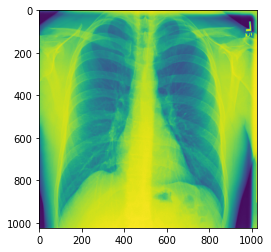

In [64]:
plt.imshow(dicom_obj.pixel_array)

In [7]:
img_path = (data_path/'train/images')
mask_path = (data_path/'train/mask')

img_path.mkdir(parents=True, exist_ok=True)
mask_path.mkdir(parents=True, exist_ok=True)

In [8]:
def save_dcm_png(file,dst_path):
    """Extracts image from DCM file and saves it as a PNG file."""
    fname = file.stem
    pyds = pydicom.dcmread(file)
    img = Image.fromarray(pyds.pixel_array)
    img.save(f'{dst_path}/{fname}.png')
    

In [62]:
save_dcm_png(train_files[1],data_path/'train/images/')

In [9]:
def save_rle_mask(df,fname,dst_path):
    """Converts mask from rle format to PIL Image format"""
    mask = np.zeros((1024,1024))
    rles = df[df['ImageId']==fname]['EncodedPixels']
    for rle in rles:
        if rle != -1:
            mask += run_length_decode(rle).T
    mask = mask.clip(0,1).astype(np.uint8) * 255
    mask = Image.fromarray(mask)
    mask.save(f'{data_path}/{fname}.png')
    
    

Sequential approach which could take close to 1 hour.


```
for file in progress_bar(train_files):
    save_dcm_png(file,data_path/'train/images/')
    save_rle_mask(train_meta,file.stem,data_path/'train/mask/')
    
```

In [15]:
def setup(file):
    save_dcm_png(file,data_path/'train/images/')
    save_rle_mask(train_meta,file.stem,data_path/'train/mask/')

In [17]:
from fastcore.parallel import parallel

In [21]:
#Lets make it faster by using all the cores.

parallel(setup, train_files, n_workers=7, progress=True)

(#12089) [None,None,None,None,None,None,None,None,None,None...]

In [22]:
len(train_files)

12089

In [ ]:
kaggle datasets download -d seesee/siim-train-test